<a href="https://colab.research.google.com/github/2020-nlp-c/nlp-statisticsmodel/blob/master/mhlee/08_Prac_2_Keyword_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8장. 핵심 키워드 추출 (Keyword Extraction)

# 8-0 데이터 준비

## Mecab 설치 (필요시)

In [ ]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 3.6MB 36.0MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing inst

# 8-1 TF-IDF 활용 핵심키워드 추출

## 실습 1. sklearn 활용


In [ ]:
import requests 
from bs4 import BeautifulSoup

def get_news_by_url(url):
  res = requests.get(url)
  bs = BeautifulSoup(res.content, 'html.parser')

  title = bs.select('h3#articleTitle')[0].text #제목
  content = bs.select('#articleBodyContents')[0].get_text().replace('\n', " ") #본문
  content = content.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
  return  content.strip()

docs = []
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=018&aid=0004430108') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=001&aid=0011614790') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=014&aid=0004424362') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=119&aid=0002402191') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002882728') )
len(docs)

5

### 1) 전처리

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

preprocessed_docs = []
for doc in docs :
  # 명사와 동사만으로 문서 전처리
  preprocessed_docs.append(' '.join([token[0] for token in mecab.pos(doc) if token[1][0] in ['N', 'V']]))
preprocessed_docs[0][:100]

'과기 정통부 일 유영민 장관 등 참석 기념행사 년 억 원 투입 여종 데이터 구축 민간 클라우드 통한 외부 연계 체계 개방 강화 데일리 이재운 기자 국가 차원 빅 데이터 활용 시대 '

### 2) TF-IDF 계산

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.85, max_features=10000)
word_count_vector = count_vectorizer.fit_transform(preprocessed_docs)
list(count_vectorizer.vocabulary_.keys())[:10]

['과기', '정통부', '유영민', '장관', '참석', '기념행사', '투입', '여종', '구축', '민간']

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

### 3) 핵심키워드 추출

In [ ]:
def sort_keywords(keywords):
    return sorted(zip(keywords.col, keywords.data), key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_keywords(feature_names, sorted_keywords, n=5):
    return [(feature_names[idx], score) for idx, score in sorted_keywords[:n]]

In [ ]:
doc = preprocessed_docs[0] # 핵심키워드 추출할 문서 조회

feature_names = count_vectorizer.get_feature_names() # TF-IDF 단어 목록
tf_idf_vector = tfidf_transformer.transform(count_vectorizer.transform([doc])) # 문서의 tf-idf 추출
sorted_keywords = sort_keywords(tf_idf_vector.tocoo()) # TF-IDF를 기준으로 역순 정렬
 
# 사용자가 지정한 갯수만큼 키워드 추출
keywords = extract_keywords(feature_names, sorted_keywords, 5)
 
print("\n===== 원문 =====")
print(docs[0][:100])
print("\n=== 핵심키워드 ===")
for k in keywords:
    print(k)


===== 원문 =====
과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 5100여종 데이터 구축민간 클라우드 통한 외부연계체계도.."개방성 강화"[이데일리 이재운 기자

=== 핵심키워드 ===
('플랫', 0.2526148007071733)
('계획', 0.21652697203472)
('정통부', 0.18043914336226666)
('과기', 0.18043914336226666)
('통해', 0.17469259767293158)


In [ ]:
tf_idf_vector.tocoo().data

array([0.03608783, 0.03608783, 0.05823087, 0.07217566, 0.03608783,
       0.03608783, 0.03608783, 0.02911543, 0.03608783, 0.14557716,
       0.03608783, 0.03608783, 0.02911543, 0.02911543, 0.07217566,
       0.11646173, 0.03608783, 0.03608783, 0.04833688, 0.03608783,
       0.03608783, 0.2526148 , 0.03608783, 0.02911543, 0.03608783,
       0.02911543, 0.02911543, 0.03608783, 0.10826349, 0.1746926 ,
       0.07217566, 0.03608783, 0.10826349, 0.03608783, 0.07217566,
       0.03608783, 0.02911543, 0.02911543, 0.07217566, 0.03608783,
       0.04066251, 0.02911543, 0.07217566, 0.03608783, 0.03608783,
       0.10826349, 0.03608783, 0.03608783, 0.10826349, 0.03608783,
       0.03608783, 0.02911543, 0.03608783, 0.03608783, 0.02911543,
       0.02911543, 0.03608783, 0.03608783, 0.10826349, 0.02911543,
       0.07217566, 0.03608783, 0.02911543, 0.03608783, 0.1208422 ,
       0.07217566, 0.18043914, 0.02911543, 0.04066251, 0.02911543,
       0.09667376, 0.07217566, 0.03608783, 0.02033125, 0.02911


---


## 실습 2. gensim 활용


### 1) 전처리

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

preprocessed_docs = []
for doc in docs :
  # 명사와 동사만으로 문서 전처리
  preprocessed_docs.append(' '.join([token[0] for token in mecab.pos(doc) if token[1][0] in ['N', 'V']]))
preprocessed_docs[0][:100]

'과기 정통부 일 유영민 장관 등 참석 기념행사 년 억 원 투입 여종 데이터 구축 민간 클라우드 통한 외부 연계 체계 개방 강화 데일리 이재운 기자 국가 차원 빅 데이터 활용 시대 '

### 2) TF-IDF 계산

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

document_ls = [doc.split() for doc in preprocessed_docs]
dct = Dictionary(document_ls) # 인덱스(key) - 단어(valuue) 인 딕셔너리 생성
corpus = [dct.doc2bow(doc) for doc in document_ls] # 각 문서에 포함된 단어를 인덱스로 변환하여 corpus 생성
tfidf = TfidfModel(corpus) # TF-IDF 산출

### 3) 핵심키워드 추출

In [ ]:
def sort_keywords(tfidf):
    return sorted(tfidf, key=lambda x: (x[1], x[0]), reverse=True)

def extract_keywords(feature_names, sorted_keywords, n=5):
    return [(feature_names[idx], score) for idx, score in sorted_keywords[:n]]

In [ ]:
doc = corpus[0]

sorted_keywords = sort_keywords(tfidf[doc]) # TF-IDF를 기준으로 역순 정렬

# 사용자가 지정한 갯수만큼 키워드 추출
keywords = extract_keywords(dct, sorted_keywords, 5)

print("\n=== 핵심키워드 ===")
for k in keywords:
    print(k)


=== 핵심키워드 ===
('플랫', 0.260111262735105)
('폼', 0.260111262735105)
('계획', 0.2229525109158043)
('정통부', 0.18579375909650356)
('과기', 0.18579375909650356)


In [ ]:
tfidf[doc]

[(0, 0.021155348483460852),
 (1, 0.011793957648078673),
 (3, 0.023587915296157346),
 (4, 0.021155348483460852),
 (5, 0.037158751819300714),
 (6, 0.037158751819300714),
 (7, 0.037158751819300714),
 (8, 0.036063616033346915),
 (9, 0.06346604545038255),
 (10, 0.037158751819300714),
 (11, 0.042310696966921704),
 (12, 0.021155348483460852),
 (13, 0.037158751819300714),
 (14, 0.021155348483460852),
 (15, 0.037158751819300714),
 (16, 0.021155348483460852),
 (17, 0.005151945147620987),
 (18, 0.07431750363860143),
 (19, 0.10577674241730427),
 (20, 0.037158751819300714),
 (21, 0.2229525109158043),
 (22, 0.037158751819300714),
 (23, 0.010303890295241975),
 (24, 0.037158751819300714),
 (25, 0.07431750363860143),
 (26, 0.037158751819300714),
 (27, 0.011793957648078673),
 (28, 0.037158751819300714),
 (29, 0.18579375909650356),
 (30, 0.042310696966921704),
 (31, 0.037158751819300714),
 (32, 0.042310696966921704),
 (33, 0.07431750363860143),
 (34, 0.011793957648078673),
 (35, 0.037158751819300714),
 (



---



# 8-2 Textrank
https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

<img src="https://3.bp.blogspot.com/-yp0Lr3ec5EY/XIs6znCcO_I/AAAAAAAAAPY/xtZxe_OYtH0xeuWsp4Qd4DQrunGMpVQmQCLcBGAs/s640/keyword-extraction-textrank.png" />

## 실습 1. 행렬 활용 


In [ ]:
import requests 
from bs4 import BeautifulSoup

def get_news_by_url(url):
  res = requests.get(url)
  bs = BeautifulSoup(res.content, 'html.parser')

  title = bs.select('h3#articleTitle')[0].text #제목
  content = bs.select('#articleBodyContents')[0].get_text().replace('\n', " ") #본문
  content = content.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
  return  content.strip()

doc = get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=018&aid=0004430108')
doc

'과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 5100여종 데이터 구축민간 클라우드 통한 외부연계체계도.."개방성 강화"[이데일리 이재운 기자] 국가 차원의 빅데이터 활용 시대가 열린다. 새로운 산업 창출과 기존 산업의 변화에 이르는 ‘혁신성장’을 위한 센터가 문을 연다. 10개 분야에 걸쳐 ‘데이터 경제’의 발전을 위한 정부의 청사진을 현실로 구현하는데 앞장선다는 계획이다.22일 과학기술정보통신부는 서울 중구 대한상공회의소에서 데이터 생태계 조성과 혁신 성장의 기반 마련을 위한 ‘빅데이터 플랫폼 및 센터’ 출범식 행사를 개최했다. 유영민 과기정통부 장관을 비롯해 노웅래 국회 과학기술정보방송통신위원회 위원장 등 300여명이 참가했다.◇10개 분야 100개 센터..3년간 1516억원 투입이미지: 픽사베이빅데이터는 데이터 활용을 통해 혁신성장을 이루자는 문재인 정부의 경제 성장 핵심 요소중 하나다. 문재인 대통령이 직접 올 들어 데이터 활용과 이에 따른 정보보호(보안)에 대한 중요성을 강조하기도 했다.이런 맥락 속에서 빅데이터센터는 공공과 민간이 협업해 활용도 높은 양질의 데이터를 생산·구축하고, 플랫폼은 이를 수집·분석·유통하는 역할을 담당한다. 과기정통부는 분야별 플랫폼 10개소와 이와 연계된 기관별 센터 100개소를 구축하는데 3년간 총 1516억원을 투입할 계획이며, 올해 우선 640억원 규모의 사업을 추진하고 있다.대상 분야는 △금융(BC카드) △환경(한국수자원공사) △문화(한국문화정보원) △교통(한국교통연구원) △헬스케어(국립암센터) △유통·소비(매일방송) △통신(KT) △중소기업(더존비즈온) △지역경제(경기도청) △산림(한국임업진흥원) 등으로 현재 1차 공모를 통해 72개 빅데이터 센터를 선정했고, 다음달 8일까지 2차 공모를 통해 28개를 추가 선정해 총 100개를 지원, 운영할 계획이다. 이를 통해 데이터 생태계를 혁신하고 기업의 경쟁력을 제고하는 역할을 수행한다.주요 활용 전략·사례를 보면 빅데이터 활용을 

### 1) 토큰화 (Tokenization)

분석 텍스트 정제

### 2) Unique한 토큰 목록 생성

그래프 생성을 위해서 Unique한 토큰 목록 생성

In [ ]:
tokens = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']
vocab = nodes

vocab2idx = {vocab[i]:i for i in range(0, len(vocab))} #vocab을 인덱스로 변환
idx2vocab = {i:vocab[i] for i in range(0, len(vocab))} #인덱스를 vocab으로 변환
vocab2idx

{'딸기': 3, '바나나': 0, '사과': 1, '파인애플': 2}

### 3) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 
*   weighted_edge 행렬은 노드간 가중치 정보를 담고 있음
*   weighted_edge[i][j] 는 i번째 단어와 j번째 단어의 가중치를 의미
*   weighted_edge[i][j] 가 0인 경우는 노드간 연결이 없음을 의미
*   모든 노드는 1로 초기화

In [ ]:
import numpy as np
import math
vocab_len = len(vocab)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
covered_coocurrences = []

for window_start in range(0,(len(tokens)-window_size+1)):
    window = tokens[window_start : window_start+window_size]
    for i in range(window_size) :
        for j in range(i+1, window_size) : 
            if (window[i] in vocab2idx.keys()) & (window[j] in vocab2idx.keys()) : #윈도 내 단어가 노드에 속하는 경우만 엣지로 연결
                index_of_i = window_start + i
                index_of_j = window_start + j
                
                if [index_of_i,index_of_j] not in covered_coocurrences:
                  weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]]=1
                  weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]]=1
                  covered_coocurrences.append([index_of_i,index_of_j])
                
for i in range(0,vocab_len):
  sumi = weighted_edge[i].sum() #각 노드별 보유한 edge 수
  weighted_edge[i] = weighted_edge[i]/sumi if sumi > 0 else 0 #edge 가중치

weighted_edge

array([[0.        , 0.5       , 0.        , 0.5       ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333334, 0.33333334, 0.33333334, 0.        ]], dtype=float32)

### 4) 각 노드의 score계산
각 노드와 연결된 weighted edge의 값을 합산

In [ ]:
MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(0,MAX_ITERATIONS):
    prev_score = np.copy(score)
    
    for i in range(0,vocab_len):        
        summation = 0
        for j in range(0,vocab_len):
            if weighted_edge[j][i] != 0:
                summation += weighted_edge[j][i]*score[j]
                
        score[i] = (1-d) + d*(summation)
    
    if np.sum(np.fabs(prev_score-score)) <= threshold: #convergence condition
        break


### 5) 핵심 단어 추출

In [ ]:
sorted_index = np.flip(np.argsort(score),0)

n = 4

print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
딸기 : 1.4668667
사과 : 0.98365426
바나나 : 0.98364776
파인애플 : 0.5656039


In [ ]:
sorted_index[0]

3

---

## 실습 2. 그래프 활용 

In [ ]:
import requests 
from bs4 import BeautifulSoup

def get_news_by_url(url):
  res = requests.get(url)
  bs = BeautifulSoup(res.content, 'html.parser')

  title = bs.select('h3#articleTitle')[0].text #제목
  content = bs.select('#articleBodyContents')[0].get_text().replace('\n', " ") #본문
  content = content.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
  return  content.strip()

doc = get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=018&aid=0004430108')
doc[:50]

'과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 510'

### 1) 토큰화 (Tokenization)

분석 텍스트 정제

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

nodes = [token for token in mecab.pos(doc) if token[1] in ['NNG','NNP']] #NNG, NNP를 스코어 계산 대상(노드)로 제한
tokens = [token for token in mecab.pos(doc)] #탐색할 토큰 전체

### 2) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 없음을 의미
*   모든 노드는 1로 초기화

In [ ]:
import numpy as np
import math
import networkx as nx

# 윈도내 동시 등장한 토큰으로 그래프를 생성
def connect(nodes, tokens) :            
    window_size = 2 # coocurrence를 판단하기 위한 window 사이즈 설정

    edges = []
    for window_start in range(0,(len(tokens)-window_size+1)):
        window = tokens[window_start:window_start+window_size]
        for i in range(window_size) :
            for j in range(i+1, window_size) : 
                if (window[i] in nodes) & (window[j] in nodes) : #윈도 내 단어가 노드에 속하는 경우만 엣지로 연결
                    edges.append((window[i], window[j]))
                    print((window[i], window[j]))
    return edges

tokens = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']

graph=nx.diamond_graph()
graph.clear() 
graph.add_nodes_from(list(set(nodes))) #node 등록
graph.add_edges_from(connect(nodes, tokens)) #edge 연결    

('딸기', '바나나')
('바나나', '사과')
('사과', '딸기')
('딸기', '파인애플')


### 3) 스코어 계산 및 핵심키워드 추출

In [ ]:
scores = nx.pagerank(graph) #pagerank 계산
rank = sorted(scores.items(), key=lambda x: x[1], reverse=True) #score 역순 정렬
print("\n=== 핵심키워드 ===")
rank[:5]


=== 핵심키워드 ===


[('딸기', 0.3667352990529791),
 ('바나나', 0.2459279727012903),
 ('사과', 0.24592797270129027),
 ('파인애플', 0.14140875554444032)]

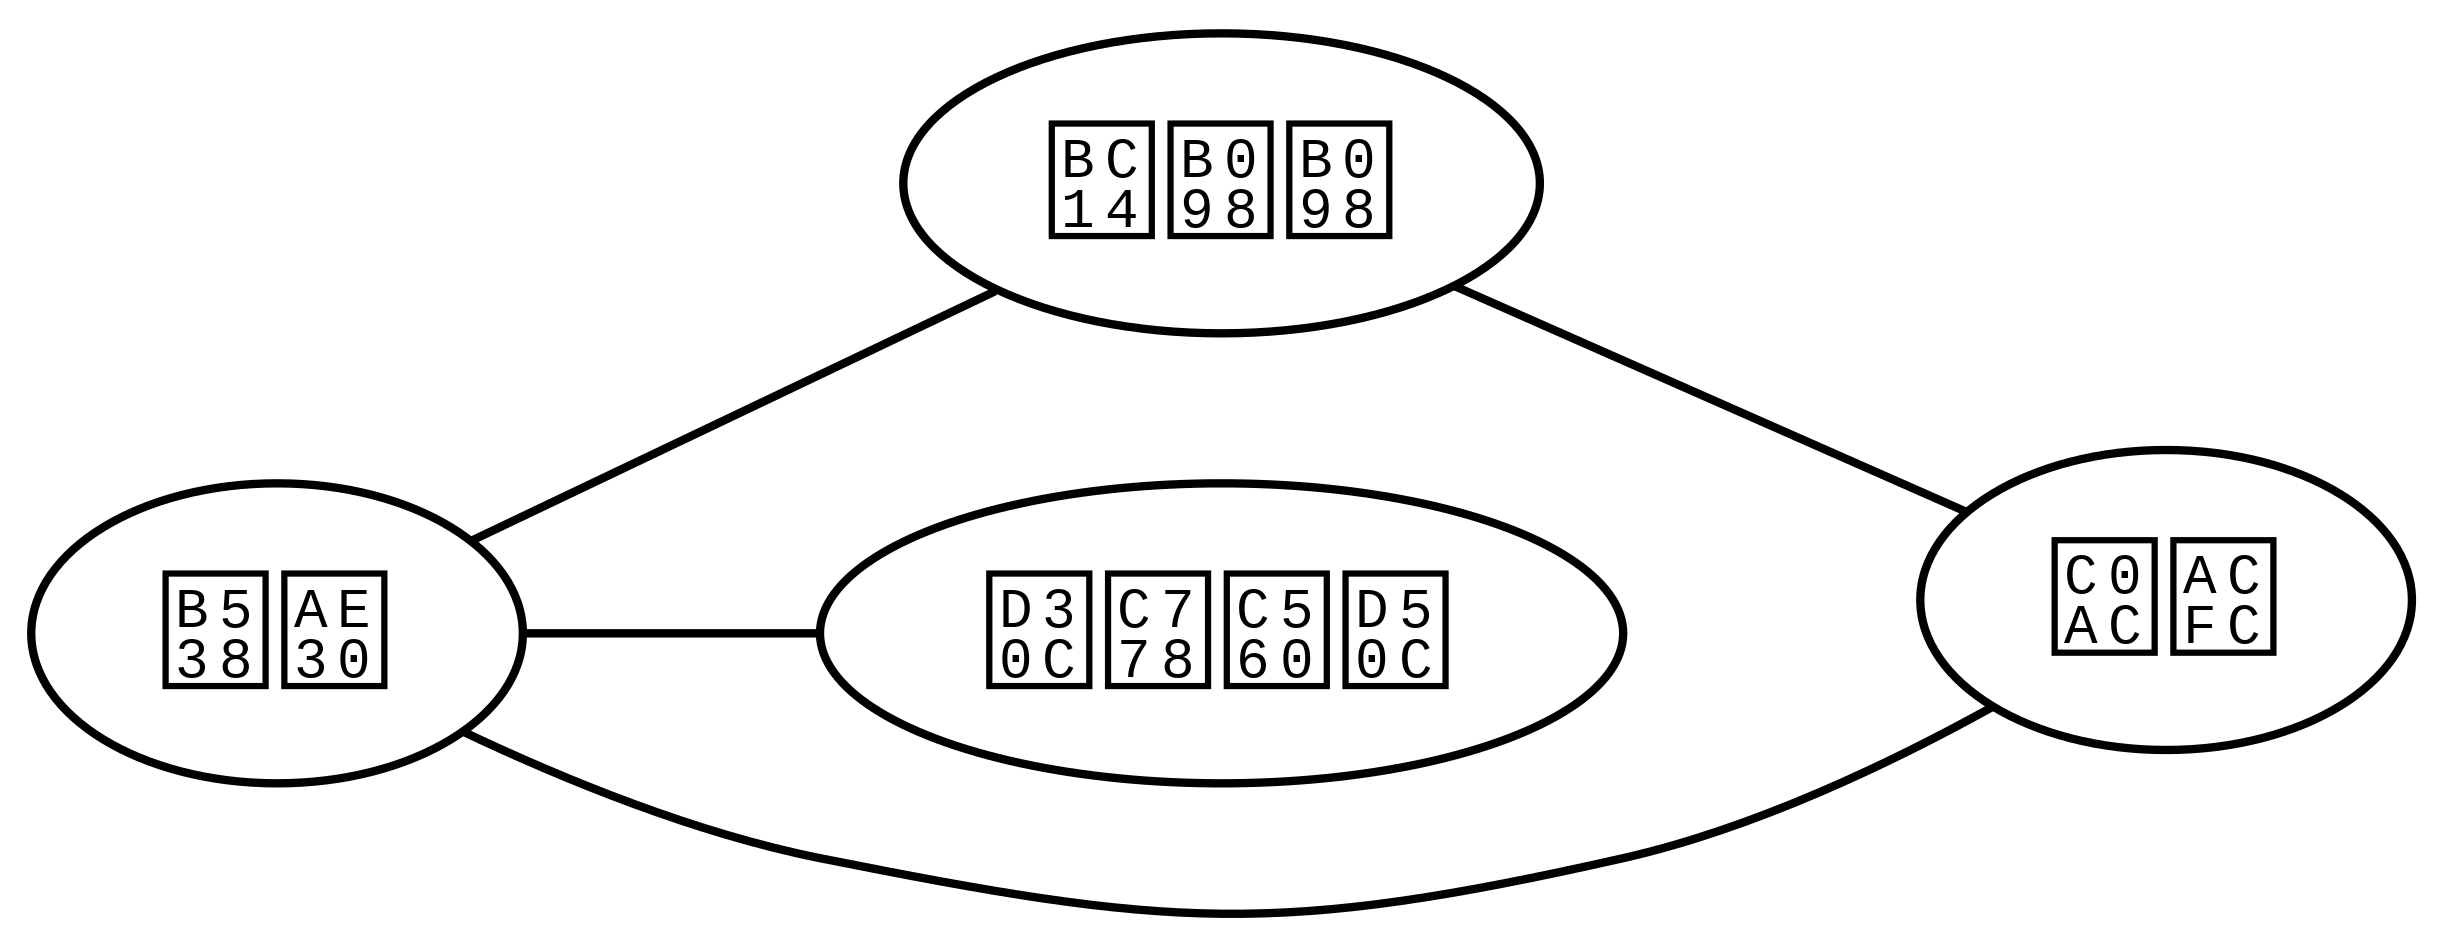

In [ ]:
import networkx as nx
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

d = to_pydot(graph)
d.set_dpi(600)
d.set_rankdir("LR")
Image(d.create_png(), width=600)

---

## 실습 3. TextRank 핵심 구 추출

### 1) 불용어를 기준으로 구 추출

In [ ]:
phrases = []
phrase = ' '

for word in tokens:
    if word[1][0] != 'N':
        if phrase != ' ':
            phrases.append(phrase.strip())
        phrase= ' '
    else:
        phrase+=word[0]
        phrase+= ' '
        
print(phrases)

['과기 정통부', '일 유영민 장관 등 참석', '기념행사', '년', '억 원 투입', '여종 데이터 구축 민간 클라우드', '외부 연계 체계', '개방', '강화', '데일리 이재운 기자', '국가 차원', '빅 데이터 활용 시대', '산업 창출', '기존 산업', '변화', '혁신', '장', '센터', '문', '개 분야', '데이터 경제', '발전', '정부', '청사진', '현실', '구현', '데', '계획', '일 과학 기술 정보 통신부', '서울 중구 대한 상공 회의소', '데이터 생태', '조성', '혁신 성장', '기반 마련', '빅 데이터 플랫 폼', '센터', '출범식 행사', '개최', '유영민 과기 정통부 장관', '노웅래 국회 과학 기술 정보 방송 통신 위원회 위원장 등', '명', '참가', '개 분야', '개 센터', '년 간', '억 원 투입 이미지', '픽사 베이 빅 데이터', '데이터 활용', '혁신', '장', '문재', '정부', '경제 성장 핵심 요소 중 하나', '문재인 대통령', '데이터 활용', '이', '정보 보호', '보안', '중요', '강조', '맥락 속', '빅 데이터 센터', '공공', '민간', '협업', '활용', '양질', '데이터', '생산', '구축', '플랫 폼', '이', '수집', '분석', '유통', '역할', '담당', '과기 정통부', '분야', '플랫 폼', '개소', '이', '연계', '기관', '센터', '개소', '구축', '데', '년', '억 원', '투입', '계획', '올해', '억 원 규모', '사업', '추진', '대상 분야', '금융', '카드', '환경', '한국 수자원 공사', '문화', '한국 문화 정보원', '교통', '한국 교통 연구원', '헬 스케어', '국립암센터', '유통', '소비', '매일 방송', '통신', '중소기업', '비즈', '지역 경제', '경기도 청', '산림', '한국 임업', '흥원', '등', '차 공모', '개 빅 데이터 

In [ ]:
unique_phrases = []

for phrase in phrases:
    if phrase not in unique_phrases:
        unique_phrases.append(phrase)

print(unique_phrases)

['과기 정통부', '일 유영민 장관 등 참석', '기념행사', '년', '억 원 투입', '여종 데이터 구축 민간 클라우드', '외부 연계 체계', '개방', '강화', '데일리 이재운 기자', '국가 차원', '빅 데이터 활용 시대', '산업 창출', '기존 산업', '변화', '혁신', '장', '센터', '문', '개 분야', '데이터 경제', '발전', '정부', '청사진', '현실', '구현', '데', '계획', '일 과학 기술 정보 통신부', '서울 중구 대한 상공 회의소', '데이터 생태', '조성', '혁신 성장', '기반 마련', '빅 데이터 플랫 폼', '출범식 행사', '개최', '유영민 과기 정통부 장관', '노웅래 국회 과학 기술 정보 방송 통신 위원회 위원장 등', '명', '참가', '개 센터', '년 간', '억 원 투입 이미지', '픽사 베이 빅 데이터', '데이터 활용', '문재', '경제 성장 핵심 요소 중 하나', '문재인 대통령', '이', '정보 보호', '보안', '중요', '강조', '맥락 속', '빅 데이터 센터', '공공', '민간', '협업', '활용', '양질', '데이터', '생산', '구축', '플랫 폼', '수집', '분석', '유통', '역할', '담당', '분야', '개소', '연계', '기관', '억 원', '투입', '올해', '억 원 규모', '사업', '추진', '대상 분야', '금융', '카드', '환경', '한국 수자원 공사', '문화', '한국 문화 정보원', '교통', '한국 교통 연구원', '헬 스케어', '국립암센터', '소비', '매일 방송', '통신', '중소기업', '비즈', '지역 경제', '경기도 청', '산림', '한국 임업', '흥원', '등', '차 공모', '개 빅 데이터 센터', '선정', '다음 달', '일', '개', '추가 선정', '지원', '운영', '데이터 생태계', '기업', '경쟁력', '제고', '수행', '주요 활용 전략', '사례', '빅 데이

### 2) 각 구의 Score 계산

앞서 산출한 각 단어별 점수를 합산

In [ ]:
vocabs = dict((r[0][0], r[1]) for r in rank)
phrase_scores = []
keywords = []

for phrase in unique_phrases:
    phrase_score = 0
    for word in phrase.split():        
        if word in vocabs.keys():
            phrase_score+=vocabs[word]
            
    phrase_scores.append((phrase, phrase_score))

                         
            

for phrase_score in phrase_scores[:10]:
    print(f"keyword: {phrase_score[0]}, Score : {phrase_score[1]}")

Keyword: '과기 정통부', Score: 0.01124933498027082
Keyword: '일 유영민 장관 등 참석', Score: 0.01304776131340155
Keyword: '기념행사', Score: 0.0022034464344388585
Keyword: '년', Score: 0
Keyword: '억 원 투입', Score: 0.0032154710386563855
Keyword: '여종 데이터 구축 민간 클라우드', Score: 0.06857882292392037
Keyword: '외부 연계 체계', Score: 0.01653296999059789
Keyword: '개방', Score: 0.007608411089591418
Keyword: '강화', Score: 0.002259829046607936
Keyword: '데일리 이재운 기자', Score: 0.016337448780957005


### 3) 각 구를 Score로 정렬하여 핵심 구 추출

In [ ]:
sorted_phrase_score = sorted(phrase_scores, key=lambda tup: tup[1], reverse=True)
sorted_phrase_score[:10]

Keywords:

여종 데이터 구축 민간 클라우드, 
빅 데이터 플랫 폼, 
빅 데이터 센터, 
개 빅 데이터 센터, 
빅 데이터 활용 시대, 
민간 사이 데이터 파일 형식 등, 
빅 데이터 활용, 
픽사 베이 빅 데이터, 
여종 데이터 구축, 
데이터 경제, 




---



## 실습 4. gensim 활용

In [ ]:
from gensim.summarization import keywords
keywords(doc, words=5).split('\n')

['데이터', '데이터를', '계획이다', '빅데이터', '문재인']